In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
from collections import defaultdict
import numpy as np

# Load Dataset
data = pd.read_csv('/content/Tempat-Wisata-Toba-Preprocessing.csv')

In [2]:
# Select Relevant Columns and Clean Data
data = data[['ReviewerId', 'PlaceID', 'Rating', 'Nama_tempat_wisata']].dropna()

# Convert columns to appropriate types
data['ReviewerId'] = data['ReviewerId'].astype(str)
data['PlaceID'] = data['PlaceID'].astype(str)
data['Rating'] = data['Rating'].astype(float)

# Prepare Data for Surprise
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data[['ReviewerId', 'PlaceID', 'Rating']], reader)

In [3]:
# Train-Test Split
trainset, testset = train_test_split(dataset, test_size=0.2)

In [4]:
# KNN Model
sim_options = {'name': 'cosine', 'user_based': False}  # Item-based
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [5]:
# Generate predictions
predictions = model.test(testset)

# Evaluate RMSE and MAE
rmse_score = rmse(predictions)
mae_score = mae(predictions)

# Precision, Recall, and MAP
def calculate_precision_recall(predictions, threshold=4.0):
    true_positive = sum((pred.r_ui >= threshold) and (pred.est >= threshold) for pred in predictions)
    false_positive = sum((pred.r_ui < threshold) and (pred.est >= threshold) for pred in predictions)
    false_negative = sum((pred.r_ui >= threshold) and (pred.est < threshold) for pred in predictions)

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return precision, recall

precision, recall = calculate_precision_recall(predictions, threshold=4.0)

def calculate_map(predictions, top_k=10):
    user_est_true = {}
    for pred in predictions:
        user_est_true.setdefault(pred.uid, []).append((pred.est, pred.r_ui))

    average_precisions = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        relevant_items = sum((true_rating >= 4.0) for (_, true_rating) in user_ratings)
        if relevant_items == 0:
            continue
        hits = 0
        precision_sum = 0
        for i, (_, true_rating) in enumerate(user_ratings[:top_k]):
            if true_rating >= 4.0:
                hits += 1
                precision_sum += hits / (i + 1)
        average_precision = precision_sum / min(relevant_items, top_k)
        average_precisions.append(average_precision)

    return np.mean(average_precisions)

map_score = calculate_map(predictions, top_k=10)

# Organize results into a DataFrame
results = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "Precision", "Recall", "MAP"],
    "Value": [rmse_score, mae_score, precision, recall, map_score]
})

# Format and display results
results["Value"] = results["Value"].astype(float)  # Ensure values are float for plotting
print(results)

RMSE: 1.0622
MAE:  0.6777
      Metric     Value
0       RMSE  1.062174
1        MAE  0.677711
2  Precision  0.888240
3     Recall  0.883432
4        MAP  0.984494


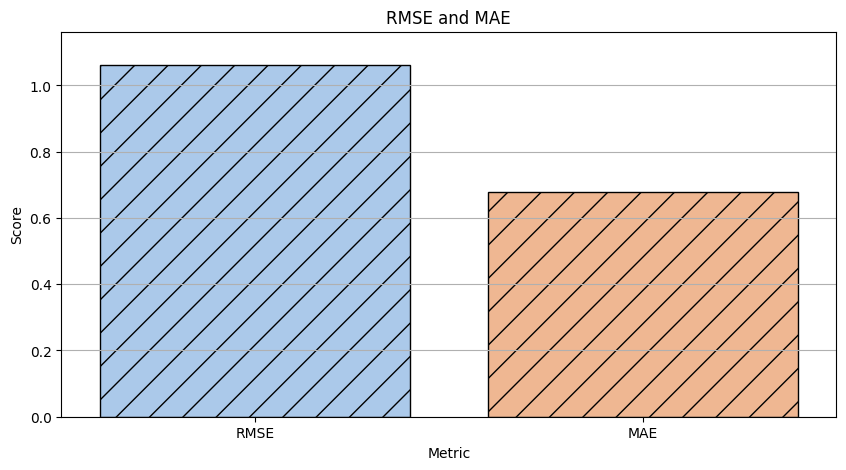

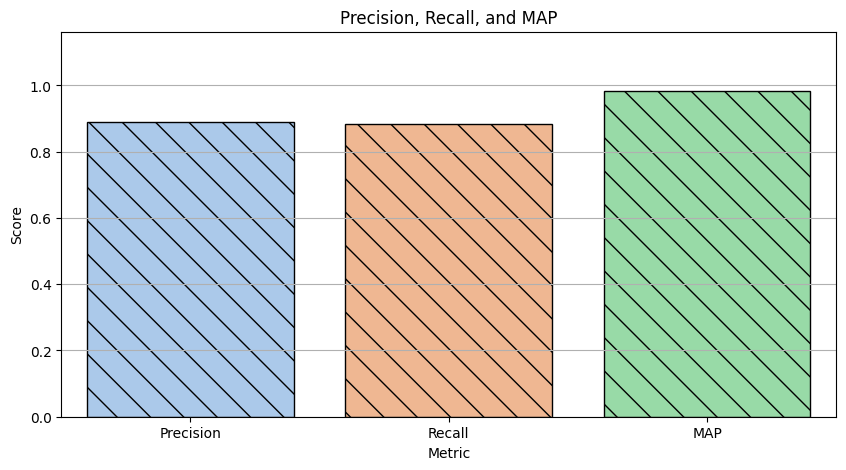

In [6]:
# Plotting RMSE and MAE
plt.figure(figsize=(10, 5))
sns.barplot(x='Metric', y='Value', data=results.iloc[:2], hue='Metric', palette='pastel', hatch='/', edgecolor='black', legend=False) # Assigned 'Metric' to hue and set legend=False
plt.title('RMSE and MAE')
plt.ylabel('Score')
plt.ylim(0, max(results['Value']) + 0.1)  # Adjust y-axis limit
plt.grid(axis='y')

# Save the first plot
plt.savefig('rmse_mae_plot.png')
plt.show()

# Plotting Precision, Recall, and MAP
plt.figure(figsize=(10, 5))
sns.barplot(x='Metric', y='Value', data=results.iloc[2:], hue='Metric', palette='pastel', hatch='\\', edgecolor='black', legend=False) # Assigned 'Metric' to hue and set legend=False
plt.title('Precision, Recall, and MAP')
plt.ylabel('Score')
plt.ylim(0, max(results['Value']) + 0.1)  # Adjust y-axis limit
plt.grid(axis='y')

# Save the second plot
plt.savefig('precision_recall_map_plot.png')
plt.show()

In [7]:
def get_top_n_recommendations_for_user(predictions, data, user_id, n=5):
    """
    Return the top-N recommendations for a specific user from a set of predictions,
    with the names of the recommended places.
    """
    # Map PlaceID to Nama_tempat_wisata
    place_names = data[['PlaceID', 'Nama_tempat_wisata']].drop_duplicates().set_index('PlaceID')['Nama_tempat_wisata'].to_dict()

    # Filter predictions for the specific user
    user_predictions = [(pred.iid, pred.est) for pred in predictions if pred.uid == user_id]

    # Sort predictions by estimated rating
    user_predictions.sort(key=lambda x: x[1], reverse=True)

    # Retrieve the top-N recommendations
    top_n = user_predictions[:n]

    # Map PlaceID to Names in the recommendations
    recommendations_with_names = [
        (place_names.get(place_id, "Nama Tidak Tersedia"), predicted_rating)
        for place_id, predicted_rating in top_n
    ]

    return recommendations_with_names

# Example: Get recommendations for a specific user
specific_user_id = "1.06792e+20"  # Replace with the actual User ID
top_recommendations_for_user = get_top_n_recommendations_for_user(predictions, data, specific_user_id, n=5)

# Display recommendations for the specific user
print(f"Top recommendations for User {specific_user_id}:")
for i, (place_name, predicted_rating) in enumerate(top_recommendations_for_user, 1):
    print(f"{i}. {place_name} (Predicted Rating: {predicted_rating:.2f})")

Top recommendations for User 1.06792e+20:
1. Pantai Lumban Bul-bul Balige (Predicted Rating: 4.66)
